In [1]:
import cv2
from google.colab.patches import cv2_imshow
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [11]:
def read_h5_images(h5_file):
    image_arrays = []
    with h5py.File(h5_file, 'r') as hf:
        keys = list(hf.keys())
        num_images = min(200, len(keys))

        for i in range(num_images):
            image_data = hf[keys[i]][()]
            image_arrays.append(image_data)

    return np.array(image_arrays)

syndrome_features = read_h5_images('syndrome_features_200.h5')
non_syndrome_features = read_h5_images('non_syndrome_features_200.h5')

print(syndrome_features.shape)
print(non_syndrome_features.shape)

(200, 3)
(200, 3)


In [12]:
import numpy as np
import torch

syndrome_features = torch.tensor(np.array(syndrome_features)).float()
print(syndrome_features.shape)

non_syndrome_features = torch.tensor(np.array(non_syndrome_features)).float()
print(non_syndrome_features.shape)

torch.Size([200, 3])
torch.Size([200, 3])


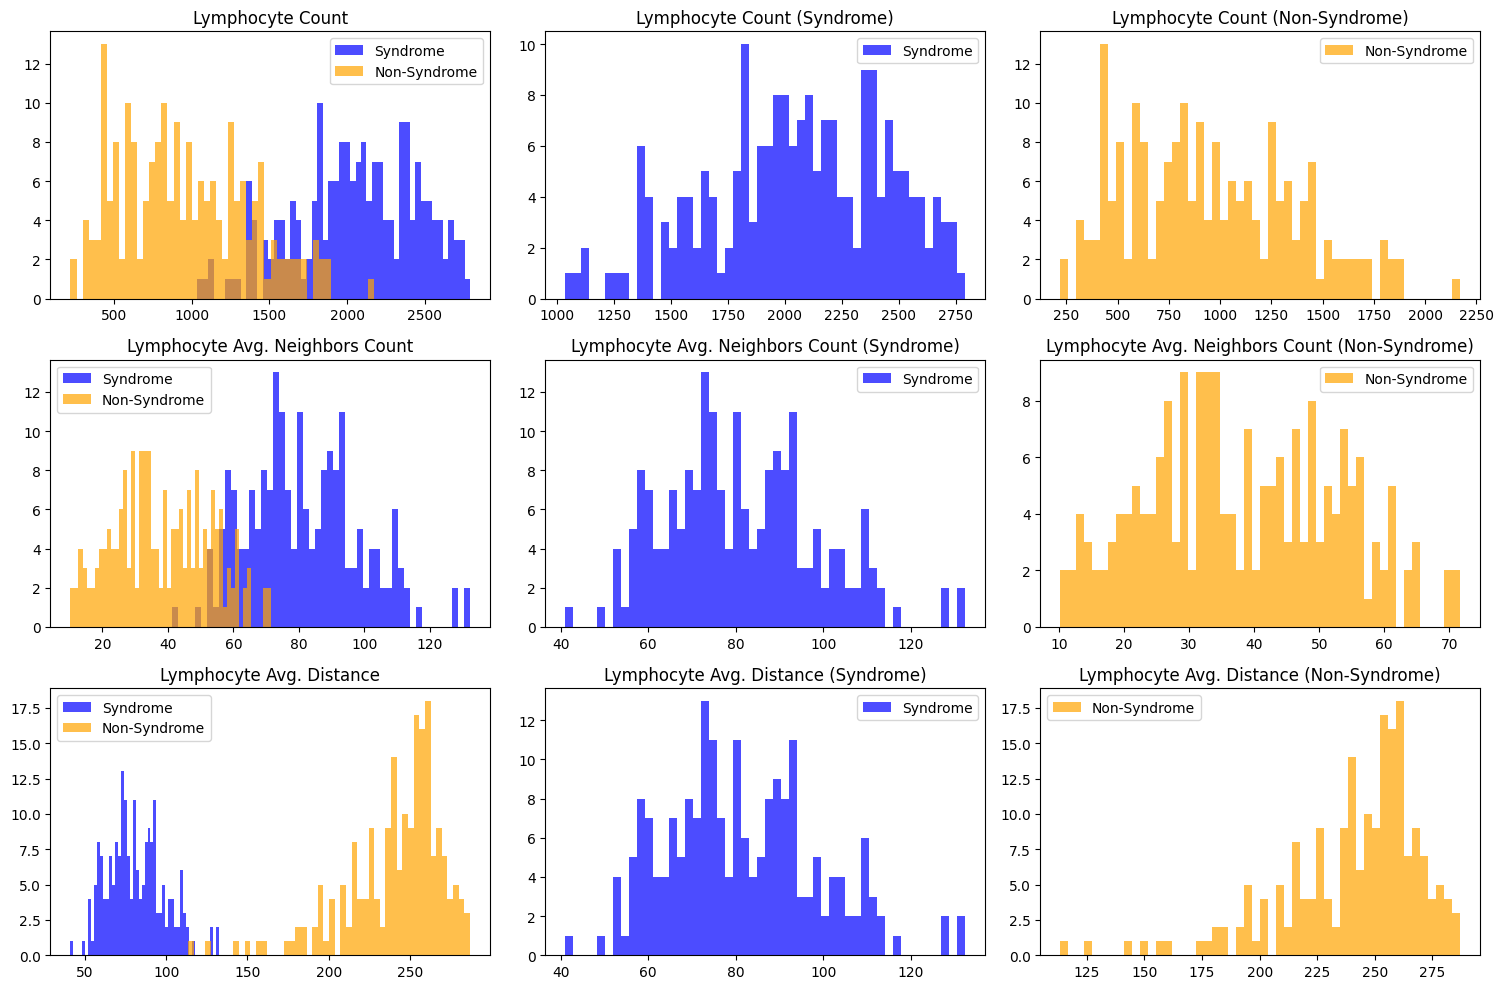

Lymphocyte Count (Syndrome) Mean: 2054.36
Lymphocyte Count (Syndrome) Std: 393.10
Lymphocyte Count (Non-Syndrome) Mean: 956.83
Lymphocyte Count (Non-Syndrome) Std: 411.29
Lymphocyte Avg. Neighbors Count (Syndrome) Mean: 81.45
Lymphocyte Avg. Neighbors Count (Syndrome) Std: 17.20
Lymphocyte Avg. Neighbors Count (Non-Syndrome) Mean: 38.34
Lymphocyte Avg. Neighbors Count (Non-Syndrome) Std: 14.52
Lymphocyte Avg. Distance (Syndrome) Mean: 81.45
Lymphocyte Avg. Distance (Syndrome) Std: 17.20
Lymphocyte Avg. Distance (Non-Syndrome) Mean: 240.75
Lymphocyte Avg. Distance (Non-Syndrome) Std: 29.96


In [16]:
# Plot connected components features
# Extract the last three columns
dark_points_count_syndrome = syndrome_features[:, 0]
avg_neighbors_count_syndrome = syndrome_features[:, 1]
avg_distance_syndrome = syndrome_features[:, -2]

dark_points_count_non_syndrome = non_syndrome_features[:, 0]
avg_neighbors_count_non_syndrome = non_syndrome_features[:, 1]
avg_distance_non_syndrome = non_syndrome_features[:, 2]

# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

# Plot dark points count
axs[0, 0].hist(dark_points_count_syndrome, bins=50, color='blue', alpha=0.7, label='Syndrome')
axs[0, 0].hist(dark_points_count_non_syndrome, bins=50, color='orange', alpha=0.7, label='Non-Syndrome')
axs[0, 0].set_title('Lymphocyte Count')
axs[0, 0].legend()

# Plot avg neighbors count
axs[1, 0].hist(avg_neighbors_count_syndrome, bins=50, color='blue', alpha=0.7, label='Syndrome')
axs[1, 0].hist(avg_neighbors_count_non_syndrome, bins=50, color='orange', alpha=0.7, label='Non-Syndrome')
axs[1, 0].set_title('Lymphocyte Avg. Neighbors Count')
axs[1, 0].legend()

# Plot avg distance
axs[2, 0].hist(avg_distance_syndrome, bins=50, color='blue', alpha=0.7, label='Syndrome')
axs[2, 0].hist(avg_distance_non_syndrome, bins=50, color='orange', alpha=0.7, label='Non-Syndrome')
axs[2, 0].set_title('Lymphocyte Avg. Distance')
axs[2, 0].legend()

# Add individual histograms for better visibility
axs[0, 1].hist(dark_points_count_syndrome, bins=50, color='blue', alpha=0.7, label='Syndrome')
axs[0, 1].set_title('Lymphocyte Count (Syndrome)')
axs[0, 1].legend()

axs[1, 1].hist(avg_neighbors_count_syndrome, bins=50, color='blue', alpha=0.7, label='Syndrome')
axs[1, 1].set_title('Lymphocyte Avg. Neighbors Count (Syndrome)')
axs[1, 1].legend()

axs[2, 1].hist(avg_distance_syndrome, bins=50, color='blue', alpha=0.7, label='Syndrome')
axs[2, 1].set_title('Lymphocyte Avg. Distance (Syndrome)')
axs[2, 1].legend()

axs[0, 2].hist(dark_points_count_non_syndrome, bins=50, color='orange', alpha=0.7, label='Non-Syndrome')
axs[0, 2].set_title('Lymphocyte Count (Non-Syndrome)')
axs[0, 2].legend()

axs[1, 2].hist(avg_neighbors_count_non_syndrome, bins=50, color='orange', alpha=0.7, label='Non-Syndrome')
axs[1, 2].set_title('Lymphocyte Avg. Neighbors Count (Non-Syndrome)')
axs[1, 2].legend()

axs[2, 2].hist(avg_distance_non_syndrome, bins=50, color='orange', alpha=0.7, label='Non-Syndrome')
axs[2, 2].set_title('Lymphocyte Avg. Distance (Non-Syndrome)')
axs[2, 2].legend()

# Adjust layout
plt.tight_layout()
plt.show()

# Statistics
print(f'Lymphocyte Count (Syndrome) Mean: {np.mean(dark_points_count_syndrome.numpy()):.2f}')
print(f'Lymphocyte Count (Syndrome) Std: {np.std(dark_points_count_syndrome.numpy()):.2f}')
print(f'Lymphocyte Count (Non-Syndrome) Mean: {np.mean(dark_points_count_non_syndrome.numpy()):.2f}')
print(f'Lymphocyte Count (Non-Syndrome) Std: {np.std(dark_points_count_non_syndrome.numpy()):.2f}')
print(f'Lymphocyte Avg. Neighbors Count (Syndrome) Mean: {np.mean(avg_neighbors_count_syndrome.numpy()):.2f}')
print(f'Lymphocyte Avg. Neighbors Count (Syndrome) Std: {np.std(avg_neighbors_count_syndrome.numpy()):.2f}')
print(f'Lymphocyte Avg. Neighbors Count (Non-Syndrome) Mean: {np.mean(avg_neighbors_count_non_syndrome.numpy()):.2f}')
print(f'Lymphocyte Avg. Neighbors Count (Non-Syndrome) Std: {np.std(avg_neighbors_count_non_syndrome.numpy()):.2f}')
print(f'Lymphocyte Avg. Distance (Syndrome) Mean: {np.mean(avg_distance_syndrome.numpy()):.2f}')
print(f'Lymphocyte Avg. Distance (Syndrome) Std: {np.std(avg_distance_syndrome.numpy()):.2f}')
print(f'Lymphocyte Avg. Distance (Non-Syndrome) Mean: {np.mean(avg_distance_non_syndrome.numpy()):.2f}')
print(f'Lymphocyte Avg. Distance (Non-Syndrome) Std: {np.std(avg_distance_non_syndrome.numpy()):.2f}')

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Function to train the model
def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    train_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(dataloader)
        train_losses.append(epoch_loss)
        #print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    return train_losses

def train_model_with_cross_validation(model, dataset, criterion, optimizer, num_epochs=10, num_folds=5):
    train_losses = []
    val_losses = []

    # Create KFold cross-validation iterator
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    for fold, (train_indices, val_indices) in enumerate(kf.split(dataset)):
        #print(f"Fold {fold + 1}/{num_folds}")

        # Create data loaders for this fold
        train_subset = torch.utils.data.Subset(dataset, train_indices)
        val_subset = torch.utils.data.Subset(dataset, val_indices)

        train_dataloader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
        val_dataloader = torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=False)

        # Reset the model for each fold
        for layer in model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

        fold_train_losses = []  # Training losses for this fold
        fold_val_losses = []  # Validation losses for this fold

        for epoch in range(num_epochs):
            model.train()
            train_running_loss = 0.0

            for inputs, labels in train_dataloader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                loss.backward()
                optimizer.step()

                train_running_loss += loss.item()

            train_epoch_loss = train_running_loss / len(train_dataloader)
            fold_train_losses.append(train_epoch_loss)
            #print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_epoch_loss:.4f}')

            model.eval()
            val_running_loss = 0.0

            with torch.no_grad():
                for inputs, labels in val_dataloader:
                    outputs = model(inputs)
                    loss = criterion(outputs.squeeze(), labels)
                    val_running_loss += loss.item()

            val_epoch_loss = val_running_loss / len(val_dataloader)
            fold_val_losses.append(val_epoch_loss)
            #print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_epoch_loss:.4f}')

        train_losses.append(fold_train_losses)
        val_losses.append(fold_val_losses)

    return train_losses, val_losses

# Function to evaluate the model
def evaluate_model(model, dataloader, original_test_data):
    model.eval()
    all_preds, all_labels = [], []

    misclassified_idxs = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            preds = (outputs.squeeze() > 0.5).int()
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())

            # Check if the prediction is incorrect
            for i, (pred, label) in enumerate(zip(preds, labels)):
                if pred != label:
                    misclassified_idxs.append(i)

    misclassified_images = original_test_data.iloc[misclassified_idxs].index.to_numpy()

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, precision, recall, f1, cm, misclassified_images

In [18]:
# Define Multi-Layer Perceptron (MLP)
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return self.sigmoid(x)

Training and evaluating split 1
Training and evaluating split 2
Training and evaluating split 3
Training and evaluating split 4
Training and evaluating split 5
Training and evaluating split 6
Training and evaluating split 7
Training and evaluating split 8
Training and evaluating split 9
Training and evaluating split 10
Training and evaluating split 11
Training and evaluating split 12
Training and evaluating split 13
Training and evaluating split 14
Training and evaluating split 15
Training and evaluating split 16
Training and evaluating split 17
Training and evaluating split 18
Training and evaluating split 19
Training and evaluating split 20
Training and evaluating split 21
Training and evaluating split 22
Training and evaluating split 23
Training and evaluating split 24
Training and evaluating split 25
Training and evaluating split 26
Training and evaluating split 27
Training and evaluating split 28
Training and evaluating split 29
Training and evaluating split 30
Training and evalua

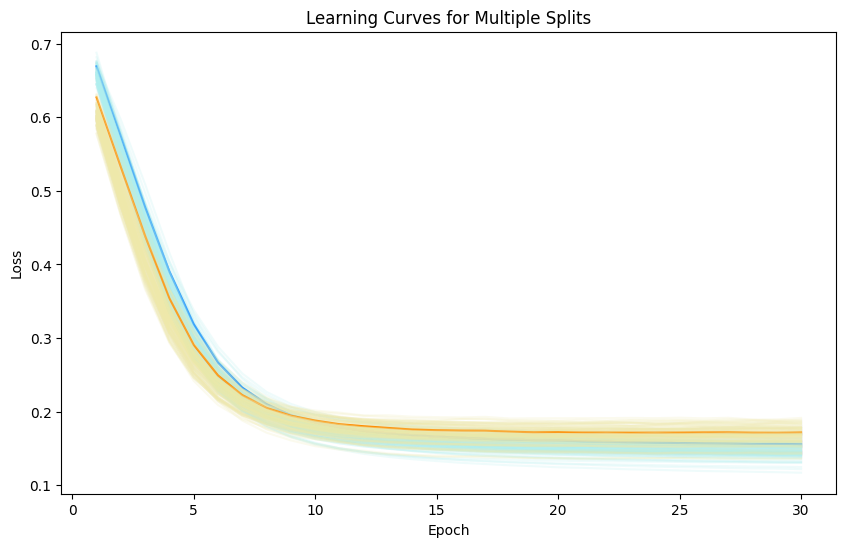

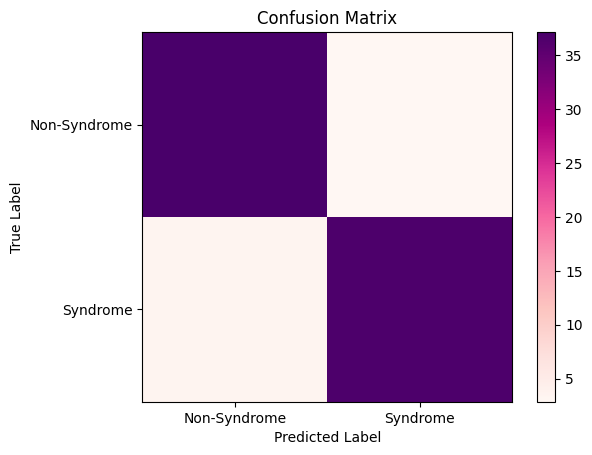

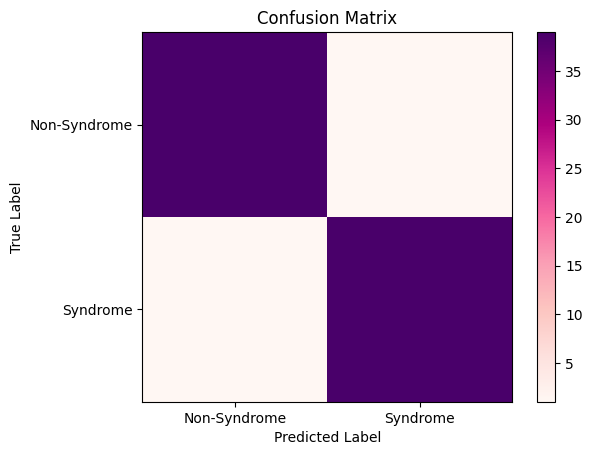

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from collections import defaultdict

# Define the number of train-test splits
num_splits = 100

# Lists to store evaluation metrics and loss curves for each split
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
all_train_avg_loss_curves = []
all_valid_avg_loss_curves = []
min_losses = []
cms = []
misclassified_images_freqs = defaultdict(int)

# Define a function to train and evaluate the model for one split
def train_and_evaluate(split_idx, data):
    print(f"Training and evaluating split {split_idx + 1}")

    indices = np.arange(len(data))
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test, _, idxs_test = train_test_split(data.drop('label', axis=1), data['label'], indices, test_size=0.2, random_state=split_idx, stratify=data['label'])
    original_test_data = data.iloc[idxs_test]

    # Standardize the features using PyTorch tensors
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

    # Create datasets and dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=40, shuffle=False)

    # Instantiate the new MLP model
    input_size = X_train.shape[1]
    hidden_size1 = 64
    hidden_size2 = 32
    output_size = 1
    mlp_model = MLP(input_size, hidden_size1, hidden_size2, output_size)

    # Define loss function and optimizer
    criterion_mlp = nn.BCELoss()
    optimizer_mlp = optim.Adam(mlp_model.parameters(), lr=0.001)

    # Train the model
    #train_losses_mlp = train_model(mlp_model, train_dataloader, criterion_mlp, optimizer_mlp, num_epochs=30)
    train_losses_mlp, val_losses_mlp = train_model_with_cross_validation(mlp_model, train_dataset, criterion_mlp, optimizer_mlp, num_epochs=30, num_folds=5)
    avg_train_losses = np.mean(train_losses_mlp, axis=0)
    avg_val_losses = np.mean(val_losses_mlp, axis=0)

    # Store the loss curve for this split
    all_train_avg_loss_curves.append(avg_train_losses)
    all_valid_avg_loss_curves.append(avg_val_losses)

    # Definite model: 5 epochs
    mlp_model = MLP(input_size, hidden_size1, hidden_size2, output_size)
    optimizer_mlp = optim.Adam(mlp_model.parameters(), lr=0.001)
    train_losses_mlp = train_model(mlp_model, train_dataloader, criterion_mlp, optimizer_mlp, num_epochs=5)

    min_loss = np.min(train_losses_mlp)
    min_losses.append(min_loss)

    # Evaluate the model
    accuracy, precision, recall, f1, cm, misclassified_images = evaluate_model(mlp_model, test_dataloader, original_test_data)
    for image_id in misclassified_images:
        misclassified_images_freqs[str(image_id)] += 1

    cms.append(cm)

    # Store evaluation metrics for this split
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

# Flatten the features
syndrome_features_flat = syndrome_features.reshape(syndrome_features.shape[0], -1)
non_syndrome_features_flat = non_syndrome_features.reshape(non_syndrome_features.shape[0], -1)

# Create labels for the features
syndrome_labels = np.ones(syndrome_features_flat.shape[0])
non_syndrome_labels = np.zeros(non_syndrome_features_flat.shape[0])

# Concatenate features and labels
all_features = np.concatenate([syndrome_features_flat, non_syndrome_features_flat], axis=0)
all_labels = np.concatenate([syndrome_labels, non_syndrome_labels], axis=0)

# Create a DataFrame
data = pd.DataFrame(data=all_features, columns=[f'feature_{i}' for i in range(all_features.shape[1])])
data['label'] = all_labels

# Run the training and evaluation loop for multiple splits
for split_idx in range(num_splits):
    train_and_evaluate(split_idx, data)

# Calculate and print average metrics
avg_accuracy = sum(accuracy_list) / len(accuracy_list)
avg_precision = sum(precision_list) / len(precision_list)
avg_recall = sum(recall_list) / len(recall_list)
avg_f1 = sum(f1_list) / len(f1_list)
avg_min_loss = sum(min_losses) / len(min_losses)
avg_cm = sum(cms) / num_splits

std_accuracy = np.std(np.array(accuracy_list))
std_precision = np.std(np.array(precision_list))
std_recall = np.std(np.array(recall_list))
std_f1 = np.std(np.array(f1_list))
std_min_loss = np.std(np.array(min_losses))
std_cm = np.array([[np.std([cm[0, 0] for cm in cms]), np.std([cm[0, 1] for cm in cms])],
                   [np.std([cm[1, 0] for cm in cms]), np.std([cm[1, 1] for cm in cms])]])

best_idx = np.argmax(np.array(f1_list))

best_accuracy = accuracy_list[best_idx]
best_precision = precision_list[best_idx]
best_recall = recall_list[best_idx]
best_f1 = f1_list[best_idx]
best_min_loss = min_losses[best_idx]
best_cm = cms[best_idx]

print()
print(f'Average Accuracy: {avg_accuracy:.8f}')
print(f'Average Precision: {avg_precision:.8f}')
print(f'Average Recall: {avg_recall:.8f}')
print(f'Average F1 Score: {avg_f1:.8f}')
print(f'Average Min Avg Loss: {avg_min_loss:.8f}')
print(f'Average Confusion Matrix: {avg_cm}')
print()

print(f'Std Accuracy: {std_accuracy:.8f}')
print(f'Std Precision: {std_precision:.8f}')
print(f'Std Recall: {std_recall:.8f}')
print(f'Std F1 Score: {std_f1:.8f}')
print(f'Std Min Avg Train Loss: {std_min_loss:.8f}')
print(f'Std Confusion Matrix: {std_cm}')
print()

print(f'Best Accuracy: {best_accuracy:.8f}')
print(f'Best Precision: {best_precision:.8f}')
print(f'Best Recall: {best_recall:.8f}')
print(f'Best F1 Score: {best_f1:.8f}')
print(f'Best Min Avg Train Loss: {best_min_loss:.8f}')
print(f'Best Confusion Matrix: {best_cm}')
print()

# Plot all the loss curves in one plot
plt.figure(figsize=(10, 6))
for i, loss_curve in enumerate(all_train_avg_loss_curves):
    plt.plot(range(1, len(loss_curve) + 1), loss_curve, color='dodgerblue' if i == best_idx else 'paleturquoise', alpha=1.0 if i == best_idx else 0.2)
for i, loss_curve in enumerate(all_valid_avg_loss_curves):
    plt.plot(range(1, len(loss_curve) + 1), loss_curve, color='darkorange' if i == best_idx else 'palegoldenrod', alpha=1.0 if i == best_idx else 0.2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curves for Multiple Splits')
plt.show()

# Plot Confusion Matrix
plt.imshow(avg_cm, interpolation='nearest', cmap=plt.cm.RdPu)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Non-Syndrome', 'Syndrome'])
plt.yticks([0, 1], ['Non-Syndrome', 'Syndrome'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

plt.imshow(best_cm, interpolation='nearest', cmap=plt.cm.RdPu)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Non-Syndrome', 'Syndrome'])
plt.yticks([0, 1], ['Non-Syndrome', 'Syndrome'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
